# Load the dataset

In [1]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
     


/home/puneet/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 194155.57 examples/s]


In [3]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
     

In [4]:

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [5]:

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [6]:
train_ds[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 3,
 'pixel_values': tensor([[[-0.0275, -0.0275, -0.0275,  ..., -0.0902, -0.0902, -0.0902],
          [-0.0275, -0.0275, -0.0275,  ..., -0.0902, -0.0902, -0.0902],
          [-0.0275, -0.0275, -0.0275,  ..., -0.0902, -0.0902, -0.0902],
          ...,
          [-0.3412, -0.3412, -0.3412,  ..., -0.0353, -0.0353, -0.0353],
          [-0.3412, -0.3412, -0.3412,  ..., -0.0353, -0.0353, -0.0353],
          [-0.3412, -0.3412, -0.3412,  ..., -0.0353, -0.0353, -0.0353]],
 
         [[-0.0353, -0.0353, -0.0353,  ..., -0.1608, -0.1608, -0.1608],
          [-0.0353, -0.0353, -0.0353,  ..., -0.1608, -0.1608, -0.1608],
          [-0.0353, -0.0353, -0.0353,  ..., -0.1608, -0.1608, -0.1608],
          ...,
          [-0.3098, -0.3098, -0.3098,  ..., -0.1608, -0.1608, -0.1608],
          [-0.3098, -0.3098, -0.3098,  ..., -0.1608, -0.1608, -0.1608],
          [-0.3098, -0.3098, -0.3098,  ..., -0.1608, -0.1608, -0.1608]],
 
  

In [8]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=64)

In [9]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)
     

pixel_values torch.Size([64, 3, 224, 224])
labels torch.Size([64])


## Define the model

In [11]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [12]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    fp16=True,
    optim="adamw_bnb_8bit"
)

/home/puneet/venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [28]:

import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [29]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.702400,0.550440,0.970000
2,0.603400,0.468616,0.968000
3,0.583500,0.451304,0.968000


TrainOutput(global_step=213, training_loss=0.6566147815453615, metrics={'train_runtime': 59.1576, 'train_samples_per_second': 228.204, 'train_steps_per_second': 3.601, 'total_flos': 1.046216869705728e+18, 'train_loss': 0.6566147815453615, 'epoch': 3.0})

In [66]:
## Evaluation
test_ds.set_transform(val_transforms)
outputs = trainer.predict(test_ds)


In [67]:
print(outputs.metrics)


{'test_loss': 0.5642439126968384, 'test_accuracy': 0.964, 'test_runtime': 3.8635, 'test_samples_per_second': 517.661, 'test_steps_per_second': 16.306}


In [61]:
## use train_transforms to get multiple predictions for single test image

test_ds.set_transform(train_transforms)


In [62]:
test_time_augmented_outputs = [ trainer.predict(test_ds) for i in range(5) ]
tta = np.array([p.predictions for p in test_time_augmented_outputs])
label_ids = test_time_augmented_outputs[0].label_ids
tta_mean = tta.mean(axis=0)
predictions = tta_mean.argmax(axis=1)

In [63]:
accuracy = np.mean(predictions == label_ids)

In [64]:
print('TTA accuracy:', accuracy)

TTA accuracy: 0.9515


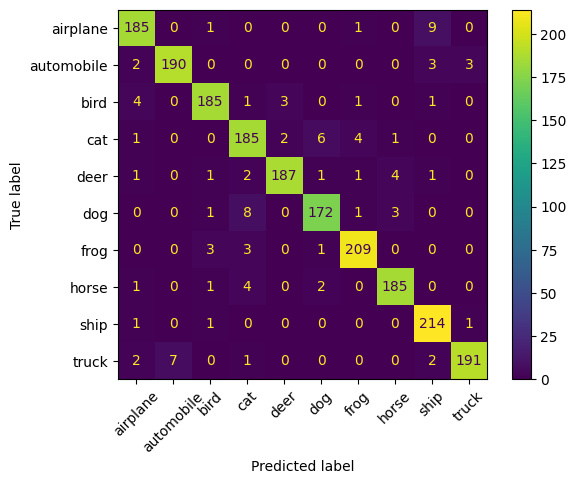

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = label_ids
y_pred = predictions

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

Test time augmentation here didn't help much